### 2023.10.19 - Introduction to Transformers | Practical Part
In this notebook, we will look at each layer of a **decoder-only gpt2-like language model**, explore their purpose and how they "act on a token". Be aware that this extremely simplified walkthrough ignores various steps required to get stable yet gpt2-like performance. It is solely designed for educational purposes. 

![Architecture Diagram](./assets/architecture-diagram.png) \
_Source:_ [Attention is all you need](https://arxiv.org/abs/1706.03762)


##### Setup

In [127]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Example Embeddings
import spacy

# To handle multi-dimensional arrays
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Dimensionality Reduction
from sklearn.manifold import TSNE

#### Layer 0: Inputs (Preprocessing)
Before an LLM can process a prompt, the natural language has to be translated into numbers. One does that by splitting the prompt into atomic units called _tokens_ and mapping them to a unique token id.
The process of splitting up text into these tokens is called _tokenization_.

In this example, we define a token as an individual word.\
Take a look at the following resources to see other strategies:
* Rule Based: [NLTK](https://www.nltk.org/)
* Byte Pair Encoding (BPE):
  * [Neural Machine Translation of Rare Words with Subword Units](https://arxiv.org/abs/1508.07909)
  * [Blog Post about BPE](https://leimao.github.io/blog/Byte-Pair-Encoding/)
* [Google's Neural Machine Translation System: Bridging the Gap between Human and Machine Translation](https://arxiv.org/abs/1609.08144)


###### class: Tokenizer

In [128]:
class Tokenizer:
    def __init__(self, vocab):
        self.vocab = vocab
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}

    def parse(self, text):
        return text.split(" ")

    def encode(self, tokens):
        return [self.token2idx[token] for token in tokens] 

    def decode(self, tokens):
        return ' '.join([self.idx2token[token] for token in tokens])

###### Input processing example

In [129]:
# Define simple full-word vocabulary
vocab = ["cat", "dog", "chicken", "sat", "on", "in", "under", "mat", "queen", "king", "the", "fish"]
print(f"Vocab length: {len(vocab)}")

# Initialize a tokenizer
tokenizer = Tokenizer(vocab) 

# Use tokenizer on example input sequence
input = "the cat sat on the mat"
print(f"Original Input: {input}")

tokens = tokenizer.parse(input)
print(f"Tokens: {tokens}")

token_ids = tokenizer.encode(tokens)
print(f"Token IDs: {token_ids}")


# Check whether our encode/decode implementation works
print(f"Decoded Tokens: {tokenizer.decode(token_ids)}")

Vocab length: 12
Original Input: the cat sat on the mat
Tokens: ['the', 'cat', 'sat', 'on', 'the', 'mat']
Token IDs: [10, 0, 3, 4, 10, 7]
Decoded Tokens: the cat sat on the mat


### Layer 1: Input Embedding
Instead of representing a word or character with a discrete ID, we map it to a high-dimensional space where similar tokens are closer, capturing the semantic relationships between tokens.
Under the hood, it is simply a _vocab_size x embedding_vector_dimension_ matrix acting as a look-up table.
In the training process, the values of the matrix change (Note: the assignment from a token to a specific row index stays the same).

_Core hypothesis:_ Words in similar contexts have similar meanings.\
Look at the following resources to learn different strategies to do that.
* Word2Vec Paper: [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781)
* GloVe: [Global Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf)
* FastText: [Enriching Word Vectors with Subword Information](https://arxiv.org/abs/1607.04606)

In [130]:
# https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
n_embd = len(vocab)
d_embd = 3
embedding_layer = nn.Embedding(n_embd, d_embd)

In [131]:
input = "the cat sat on the mat"
tokens = tokenizer.parse(input)
token_ids = torch.tensor(tokenizer.encode(tokens))
word_embeddings = embedding_layer(token_ids)
print(f"Input token: {tokens}\n")
print(f"Input token ids: {token_ids}\n")
# hint: detach() detaches a tensor from the current computational graph
print(f"Word Embeddings for the input token ids:\n{word_embeddings.detach()}") 

Input token: ['the', 'cat', 'sat', 'on', 'the', 'mat']

Input token ids: tensor([10,  0,  3,  4, 10,  7])

Word Embeddings for the input token ids:
tensor([[-1.0287, -0.9079, -0.4471],
        [-1.6279,  1.5482, -0.5728],
        [ 0.7785, -0.0492,  0.6593],
        [ 0.0534,  0.1776,  1.9464],
        [-1.0287, -0.9079, -0.4471],
        [-0.6136,  1.1514, -1.9751]])


#### Vizualization a pre-trained embedding layer to see how it captures semantic meaning
Check out this [Word2Vec Visualization](https://projector.tensorflow.org/) for real-world examples.

For this lecture, we will look at a smaller set of words: https://spacy.io/models/en \
To download the embeddings run the following command: ```python -m spacy download en_core_web_sm```

##### Words of interest
To keep our visualization clean we will only use a subset of words from the data set.

In [132]:
vocab = [
    # Structural words
    "a", "an", "the", "is", "are", "was", "were", "and", "or", "but", "if", "so",
    "that", "this", "it", "of", "to", "in", "on", "with", "for", "as",
    # Common nouns
    "man", "woman", "child", "day", "night", "time", "world", "life", "year", "hand",
    "part", "place", "case", "group", "problem", "fact",
    # Common verbs (in base form for simplicity)
    "be", "have", "do", "say", "get", "make", "go", "know", "take", "see",
    "come", "think", "look", "want", "give", "use", "find", "tell", "ask", "work", "call",
    # Common adjectives
    "good", "new", "first", "last", "long", "great", "little", "own", "other", "old", "right",
    "big", "high", "different", "small", "large", "next", "early", "young", "important",
    "few", "public", "bad", "same", "able",
    # Common adverbs
    "up", "so", "out", "just", "now", "how", "then", "more", "also", "here", "well", "only",
    "very", "even", "back", "there", "down", "still", "in", "as", "too", "when", "never",
    "really", "most",
    # Some random additional words to create diversity
    "people", "history", "way", "art", "world", "information", "map", "family", "government",
    "health", "system", "computer", "meat", "year", "music", "person", "reading",
    "method", "data", "food", "understanding", "theory", "law", "bird", "literature", "problem",
    "software", "control", "knowledge", "power", "ability", "nature", "fact", "product", "idea",
    "area", "story", "concept", "head", "wood", "research", "series", "language", "video",
    "temperature", "week", "solution", "magnitude", "room", "idea", "society", "speaking",
    "term", "book", "actor", "battery", "direction", "strategy", "army", "camera", "freedom",
    "paper", "environment", "child", "instance", "month", "truth", "marketing", "university",
    "writing", "article", "department", "difference", "goal", "news", "audience", "fishing",
    "growth", "income", "marriage", "user", "combination", "failure", "meaning", "medicine",
    "philosophy", "teacher", "communication", "night", "chemistry", "disease", "disk", "energy",
    "nation", "road", "role", "soup", "advertising", "location",
]

##### Visualization

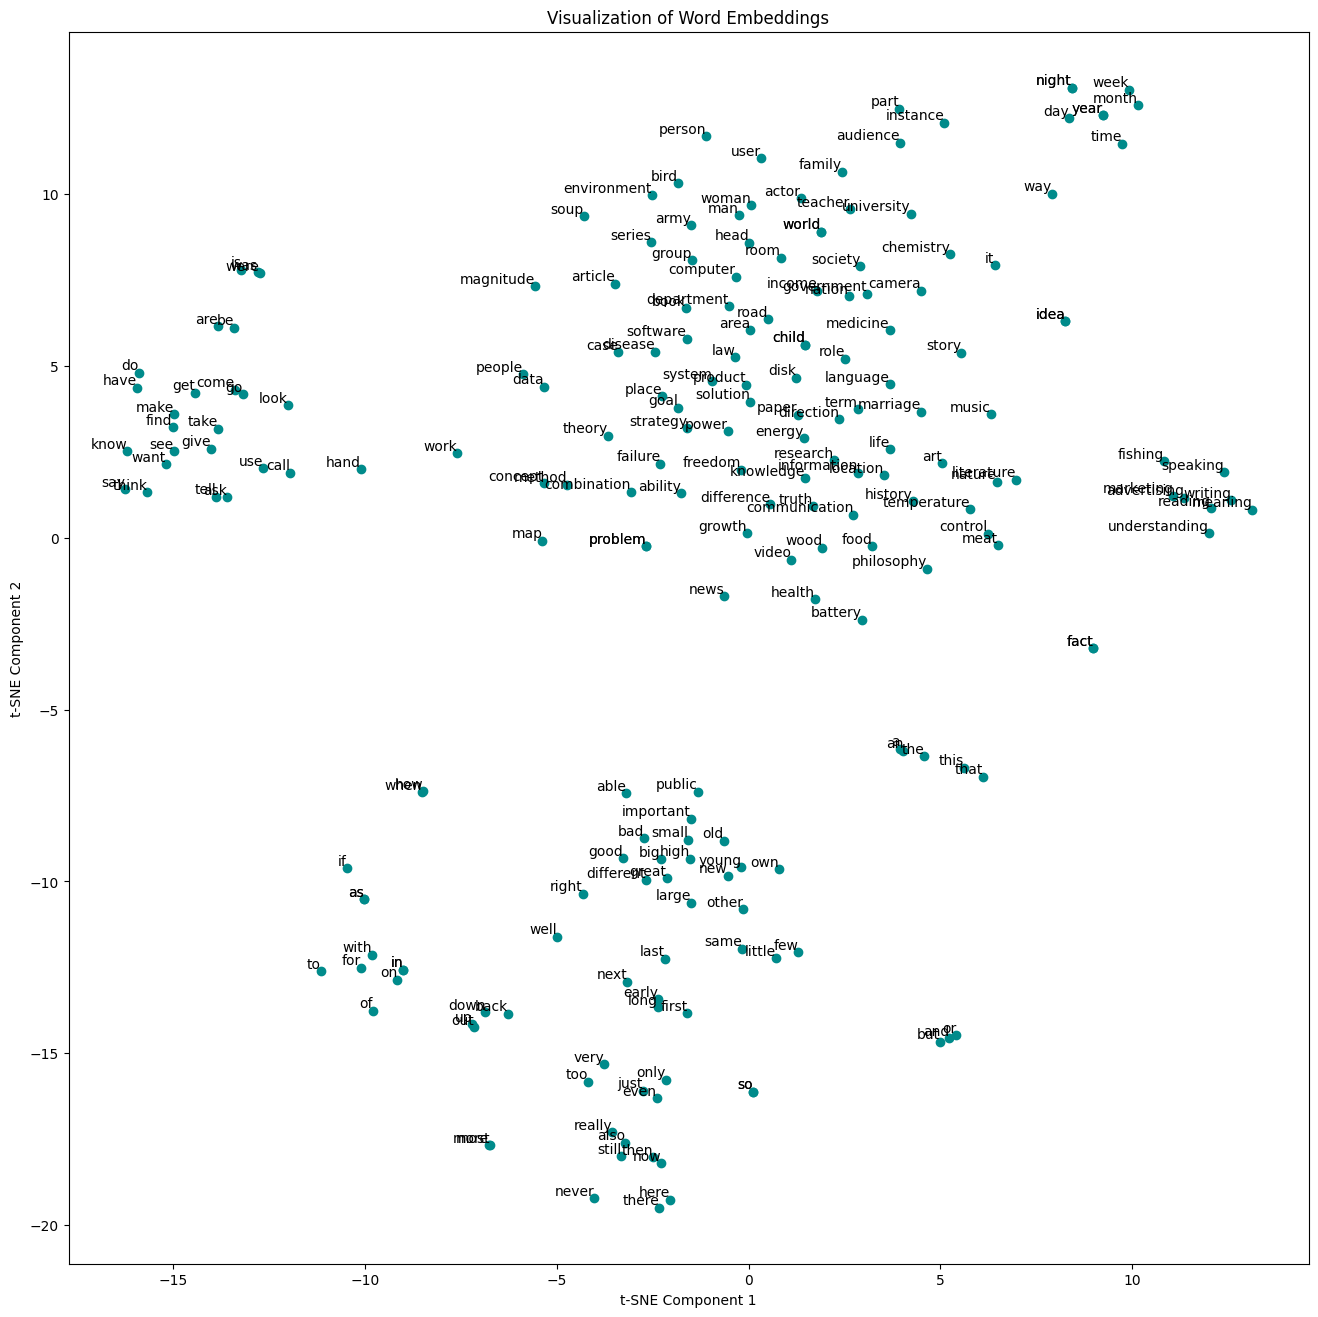

In [133]:
# Load the small English model
nlp = spacy.load('en_core_web_sm')

# Extract embeddings for the defined list
embeddings = np.array([nlp(word).vector for word in vocab])

# Reduce dimensionality using t-SNE
tsne_embeddings = TSNE(random_state=42).fit_transform(embeddings)

# Plot
plt.figure(figsize=(16, 16))
for i, word in enumerate(vocab):
    plt.scatter(tsne_embeddings[i, 0], tsne_embeddings[i, 1], color="darkcyan")
    plt.annotate(word, xy=(tsne_embeddings[i, 0], tsne_embeddings[i, 1]), ha='right', va='bottom')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Visualization of Word Embeddings")
plt.show()

### Layer 2: Positional Encoding
In natural language, the order of tokens in a sequence is vital. The embedding layer only provides information about the individual tokens and lacks context regarding their relative position in a sequence.

The original transformer paper introduced fixed encodings:\
For event positions: $𝑃𝐸(pos,2𝑖) = sin(pos/10000^{2𝑖/𝑑_{model}})$\
For uneven positions: $𝑃𝐸(pos,2𝑖+1) = cos(pos/10000^{2𝑖/𝑑_{model}})$
 
GPT uses another embedding layer to introduce "learnable" positional encoding.

_Info:_ 
- context window = n_ctx .... the maximum number of tokens a model can handle in a single input sequence

In [134]:
# Map the position index [0, 1, 2, 3, 4, ..., context_window-1] to a d_embd dimensional vector space
n_ctx = 10
pos_embedding_layer = nn.Embedding(n_ctx, d_embd)
pos = torch.arange(n_ctx) # generates array from 0 to n_ctx
print(f"Positions: {pos}")

pos_embedding = pos_embedding_layer(pos)
print(f"Position Embeddings:\n{pos_embedding.detach()}")

Positions: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Position Embeddings:
tensor([[-0.5332,  0.6929, -0.2076],
        [-1.6796, -2.5013,  1.3580],
        [ 1.4410,  0.7504,  0.4922],
        [ 0.7039, -1.0774,  0.0362],
        [ 0.9778,  0.2337,  1.8457],
        [ 0.2100, -0.1688,  0.3345],
        [-0.3573,  0.5331,  0.1146],
        [-0.8187,  0.2129,  2.6665],
        [ 0.4997,  1.8735, -1.7943],
        [-0.0395, -0.0205, -1.6768]])


### Layer 1 + Layer 2: Combinding Word and Position Embeddings

In [135]:
# Define simple full-word vocabulary
vocab = ["cat", "dog", "chicken", "sat", "on", "in", "under", "mat", "queen", "king", "the", "fish"]
tokenizer = Tokenizer(vocab)

input = "the cat sat on the mat"
tokens = tokenizer.parse(input)
token_ids = torch.tensor(tokenizer.encode(tokens))

# model config
"""
Note: To add the word_embeddings and pos_embeddings, the arrays need to have the same length
There are two options:
1: set the context window size to the sequence length
2: Use a fixed context window size and crop or pad your input string.
Option 1 was chosen for simplicity
"""
n_ctx = len(tokens) # gpt2 = 1024
n_embd = len(vocab) # gpt2 = 50 257
d_embd = 3          # gpt2 published different size version from 768 up to 1600

pos = torch.arange(0, n_ctx, dtype=torch.long)

# Model
embedding_layer = nn.Embedding(n_embd, d_embd)
pos_embedding_layer = nn.Embedding(n_ctx, d_embd)

In [136]:
word_embeddings = embedding_layer(token_ids)
pos_embedding = pos_embedding_layer(pos)

result = word_embeddings + pos_embedding

print(f"Original Text: {input}")
print(f"Tokens: {token_ids}\n")

print(f"Word Embeddings:\n{word_embeddings.detach()}\n")
print(f"Positional Embeddings:\n{pos_embedding.detach()}\n")
print(f"Result:\n{result.detach()}")

Original Text: the cat sat on the mat
Tokens: tensor([10,  0,  3,  4, 10,  7])

Word Embeddings:
tensor([[-0.0918, -1.4287, -1.8368],
        [-1.4035,  1.4480,  0.9849],
        [ 0.2973, -0.8827,  1.2228],
        [-0.9183, -0.4035,  2.0384],
        [-0.0918, -1.4287, -1.8368],
        [ 1.2547,  0.8172,  1.0027]])

Positional Embeddings:
tensor([[ 1.0271, -0.2640,  0.4288],
        [-0.0241,  2.2700, -2.0023],
        [ 0.7081,  0.6316,  0.2511],
        [ 0.2223,  1.2643,  1.0185],
        [-0.2777, -0.5268,  0.4591],
        [ 0.6021, -1.4250, -0.0642]])

Result:
tensor([[ 0.9353, -1.6928, -1.4081],
        [-1.4276,  3.7180, -1.0174],
        [ 1.0054, -0.2511,  1.4739],
        [-0.6960,  0.8608,  3.0569],
        [-0.3695, -1.9556, -1.3777],
        [ 1.8568, -0.6078,  0.9385]])
